
# Lorenz 63 Model Code for Project \# 1

### Program to investigate concepts of tangent linear models, adjoint sensitivity, and singular vectors with the Lorenz 63 model
    

In [57]:
import numpy as np # NumPy for numerical computations
import matplotlib.pyplot as plt # Matplotlib for plotting
import pandas as pd
import seaborn as sns

This is a program to investigate concepts of tangent linear models, adjoint sensitivity, and singular vectors with the Lorenz 63 model.
   - Aneesh Subramanian, September 2023

   - Ryan Torn, August 2020,
   - using matlab code originally developed by Greg Hakim

### Define the Lorenz 63 model equations

In [58]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Calculate the right-hand side of the Lorenz 63 model equations.

    Parameters:
    x, y, z : float
        The current state variables.
    s, r, b : float, optional
        The parameters for the Lorenz equations. Default values are s=10, r=28, b=2.667.

    Returns:
    dxdt, dydt, dzdt : float
        The rate of change of the state variables.
    """
    dxdt = s * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return dxdt, dydt, dzdt

###  Compute the tangent linear model matrix for Lorenz 63 model by brute force based on input forecast trajectory

In [59]:
def lorenz_tlm(tvec, x, y, z, s=10, r=28, b=2.667):
    """
    Compute the tangent linear model (TLM) matrix for the Lorenz 63 system.
    Tangent linear model also sometimes called propogator matrix.

    This function calculates the TLM by integrating the linearized equations
    along a given trajectory.

    Parameters:
    tvec (array): Time vector for the trajectory
    x, y, z (arrays): State variables of the Lorenz system along the trajectory
    s, r, b (float): Lorenz system parameters (default: s=10, r=28, b=2.667)

    Returns:
    M (numpy.ndarray): The tangent linear model matrix

    The TLM is computed using the following steps:
    1. Initialize three basis vectors (v1, v2, v3)
    2. For each time step:
       a. Compute the instantaneous Jacobian matrix (tlm)
       b. Evolve each basis vector using the Jacobian
    3. Combine the final basis vectors to form the TLM matrix
    """
    # Initialize basis vectors
    v1 = np.array([1, 0, 0])
    v2 = np.array([0, 1, 0])
    v3 = np.array([0, 0, 1])

    for t in range(len(tvec) - 1):
        # Compute the instantaneous Jacobian matrix
        tlm = np.array([
            [-s,     s,      0],
            [(r - z[t]), -1., -x[t]],
            [y[t],   x[t],   -b]
        ])

        # Time step for this iteration
        dt = tvec[t + 1] - tvec[t]

        # Evolve each basis vector
        v1 = v1 + np.matmul(tlm, v1) * dt
        v2 = v2 + np.matmul(tlm, v2) * dt
        v3 = v3 + np.matmul(tlm, v3) * dt

    # Combine the evolved basis vectors to form the TLM matrix
    M = np.transpose([v1, v2, v3])

    return M

###  Compute the distance between two points in Lorenz 63 space based on Euclidean distance norm

In [60]:
def euclid_norm(x1, y1, z1, x2, y2, z2, verbose = False):
    if(verbose):
        print("x, y, z error: ", x2 - x1, y2 - y1, z2 - z1)

    err = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    return err

### Define model parameters (timestep, number of steps, forecast length...)

In [61]:
dt = 0.002  # time step of the model (do not need to change)
num_steps = 20000  # Number of time steps for full model trajectory

step1 = 1000  # model time step to initiate forecast from
fcst_len = 1.0  # forecast length in model timesteps
tl_freq = 1  # frequency of model timesteps to use in computing tangent linear model
sing_val = 1  # singular value plot/compute
ic_error = np.array([0.1, 0.1, 0.1])  # initial condition error to add to forecast ## identical in all directions initially
xf_sens = np.array([0., 0., 1.])  # metric to compute sensitivity in x, y, z space (0, 0, 1) means compute sensitivity of z forecast

plot3d = True  # True to plot forecast in 3D space
plotxz = True  # True to plot in x-z plane
plot_nlfcst = False  # True to plt non-linear forecast
plot_sv = True  # True to plot singular vectors
sv_plot_freq = 20  # Frequency of time steps to plot singular vectors

fcst_steps = int(fcst_len / dt)

###  Create arrays needed for calculations.  Need one more for the initial values

In [62]:
xtraj = np.empty(num_steps + 1) # Full x trajectory
ytraj = np.empty(num_steps + 1) # Full y trajectory
ztraj = np.empty(num_steps + 1) # Full z trajectory

### Set initial values for the full trajectory

In [63]:
xtraj[0], ytraj[0], ztraj[0] = (0., 1., 1.05)

Step through time, calculating the partial derivatives at the current point and using them to estimate the next point

In [64]:
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xtraj[i], ytraj[i], ztraj[i])
    xtraj[i + 1] = xtraj[i] + (x_dot * dt)
    ytraj[i + 1] = ytraj[i] + (y_dot * dt)
    ztraj[i + 1] = ztraj[i] + (z_dot * dt)


# Project 1 #


In [65]:
dt = 0.002  # time step of the model (do not need to change)
num_steps = 20000  # Number of time steps for full model trajectory

step1 = 1000  # model time step to initiate forecast from
fcst_len = 1.0  # forecast length in model timesteps
tl_freq = 1  # frequency of model timesteps to use in computing tangent linear model
sing_val = 1  # singular value plot/compute
ic_error = np.array([0.1, 0.1, 0.1])  # initial condition error to add to forecast ## identical in all directions initially
xf_sens = np.array([0., 0., 1.])  # metric to compute sensitivity in x, y, z space (0, 0, 1) means compute sensitivity of z forecast

plot3d = True  # True to plot forecast in 3D space
plotxz = True  # True to plot in x-z plane
plot_nlfcst = False  # True to plt non-linear forecast
plot_sv = True  # True to plot singular vectors
sv_plot_freq = 20  # Frequency of time steps to plot singular vectors

fcst_steps = int(fcst_len / dt)

In [66]:
## Functions do not currently allow for modification of tl_freq, they will eventually!
def find_xyz_truth(xtraj, ytraj, ztraj, init_step, fcst_steps):
    xtrue = xtraj[init_step:init_step+fcst_steps+1]
    ytrue = ytraj[init_step:init_step+fcst_steps+1]
    ztrue = ztraj[init_step:init_step+fcst_steps+1]
    return(xtrue, ytrue, ztrue)

def find_xyz_fcst(xtraj, ytraj, ztraj, init_step, fcst_steps, ic_error):
    xfcst = np.empty(fcst_steps + 1) # x forecast with initial condition error
    yfcst = np.empty(fcst_steps + 1) # y forecast with initial condition error
    zfcst = np.empty(fcst_steps + 1) # z forecast with initial condition error

    xfcst[0] = xtraj[init_step] + ic_error[0]
    yfcst[0] = ytraj[init_step] + ic_error[1]
    zfcst[0] = ztraj[init_step] + ic_error[2]
    
    for i in range(fcst_steps):
        x_dot, y_dot, z_dot = lorenz(xfcst[i], yfcst[i], zfcst[i])
        xfcst[i + 1] = xfcst[i] + (x_dot * dt)
        yfcst[i + 1] = yfcst[i] + (y_dot * dt)
        zfcst[i + 1] = zfcst[i] + (z_dot * dt)
    
    return (xfcst, yfcst, zfcst)

In [67]:
def find_error_for_windows(trajectories, fcst_len=1.0, window_freq=500, dt=0.002, ic_error=np.array([0.1, 0.1, 0.1]), tl_freq=1):
    """
    Takes in parameters for finding the TLM starting at a variety of time steps specified by window_freq
    
    Args:
        *trajectories<tuple>: (xtraj, ytraj, ztraj) (assumed to have 20000 steps)
        *fcst_len<int>: length of forecast window (which will determine number of steps per window w/ dt)
        *window_freq<int>: how often to take a new starting point
        *dt<float>: resolution of time with which to step through the forecast and TLM generation
        *ic_error<list>: [x_err, y_err, z_err] initial isostatic error to apply to the forecast
        *tl_freq<float>: period of time steps to calculate TLM with
    """

    xtraj, ytraj, ztraj = trajectories # extract trajectories
    
    fcst_steps = int(fcst_len / dt) # number of steps in a window based on dt
    
    ## Changing the window starting point 
    init_steps = np.arange(0,(20000-fcst_steps+window_freq),window_freq, dtype = int) 
    # starting step for each iteration, windows of 500 and steps of 250 between them, 
    # so half and half overlap

    time_tlm = np.arange(0, (fcst_steps)*dt, dt) 
    error_compilation = [] ## will store all of the necessary info for each run as a tuple
    ## e.g. (initial_step, propogator_matrix, tlm_error_euclidian, nonlin_model_error)

    for step in init_steps:
        xtrue,ytrue,ztrue = find_xyz_truth(xtraj,ytraj,ztraj,step,fcst_steps)
        xfcst,yfcst,zfcst = find_xyz_fcst(xtraj,ytraj,ztraj,step,fcst_steps,ic_error)

        ## Propogator Matrix and Projected xyz error
        M = lorenz_tlm(time_tlm[::tl_freq], xtrue[:-1:tl_freq], ytrue[:-1:tl_freq], ztrue[:-1:tl_freq])
        tlm_error_xyz = np.matmul(M, ic_error) # propogating initial condition error forward

        ## Euclidian Error Calculations (total distance from true trajectory)
        tlm_error = euclid_norm(tlm_error_xyz[0], tlm_error_xyz[1], tlm_error_xyz[2], 0.0, 0.0, 0.0)
        fcst_error = euclid_norm(xfcst[-1], yfcst[-1], zfcst[-1], xtrue[-1], ytrue[-1], ztrue[-1])

        ## Final list of stuff to add to record
        ## Form of [initial_step,tlm_error_euclidian, nonlin_model_error, propogator_matrix]
        step_results = [step,tlm_error, fcst_error,M]
        error_compilation.append(step_results)
        
    return error_compilation

## Question \#1 ##

Run the model in the default configuration we have used in class. We will call this the control
trajectory of the model. For a variety of points along the control trajectory, compute the propagator
matrix (M) for a 1.0 time unit forecast (hereafter denoted tf ) using the code provided. At each
of these points, use the propagator matrix to predict the forecast error via the Euclidean norm for
different sized isotropic initial condition errors (i.e., change the magnitude of the error in variable
ic_error)). Next, compute the forecast error with the non-linear model by adding the isotropic
error to the control trajectory and integrating the nonlinear model forward. How does the linear
prediction of the forecast error compare to the actual error? Are there locations within the state
space volume where the linear model errors disagree with the nonlinear model? What does that
say about the Lorenz 63 model at these points?
----
General Approach:
* Initial step every 250 steps, still using a 500 step window for each TLM
* Extract errors for each window and compare visually/statistically 
* Vary isotropic error to test different pieces of the trajectory

In [79]:
isotropic_range = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]#,1.5,2.0,2.5,5.0,7.5,10.0]
error_difference = pd.DataFrame(columns = isotropic_range)
TLM_error = pd.DataFrame(columns = isotropic_range)
fcst_error = pd.DataFrame(columns = isotropic_range)

for error in isotropic_range:
    ## Get error and TLM for given frequency across all possible windows
    window_result = find_error_for_windows(trajectories = (xtraj,ytraj,ztraj),window_freq=250, ic_error=np.array([error,error,error]))
    
    #TLM_comp = [[window[0], window[3]] for window in window_result]
    #error_comp = np.array([np.array([window[0], window[1], window[2], np.abs(window[1]-window[2])]) for window in window_result])
    
    error_difference[error] = np.array([np.abs(window[1]-window[2]) for window in window_result])
    fcst_error[error] = np.array([window[2] for window in window_result])
    TLM_error[error] = np.array([window[1] for window in window_result])

initial_steps = [window[0] for window in window_result] # extracting step intervals

In [80]:
error_difference.index = initial_steps
error_difference.index.name = "Initial_Step"
error_difference.columns.name = "Isotropic_Error_xyz"
error_difference.data_information = "Absolute value of difference in error Between forecast and linear estimation"

fcst_error.index = initial_steps
fcst_error.index.name = "Initial_Step"
fcst_error.columns.name = "Isotropic_Error_xyz"
fcst_error.data_information = "Propogated forecast error starting at different time steps for a 500 step window."

TLM_error.index = initial_steps
TLM_error.index.name = "Initial_Step"
TLM_error.columns.name = "Isotropic_Error_xyz"
TLM_error.data_information = "Estimate error using a TLM for a 500 step window."

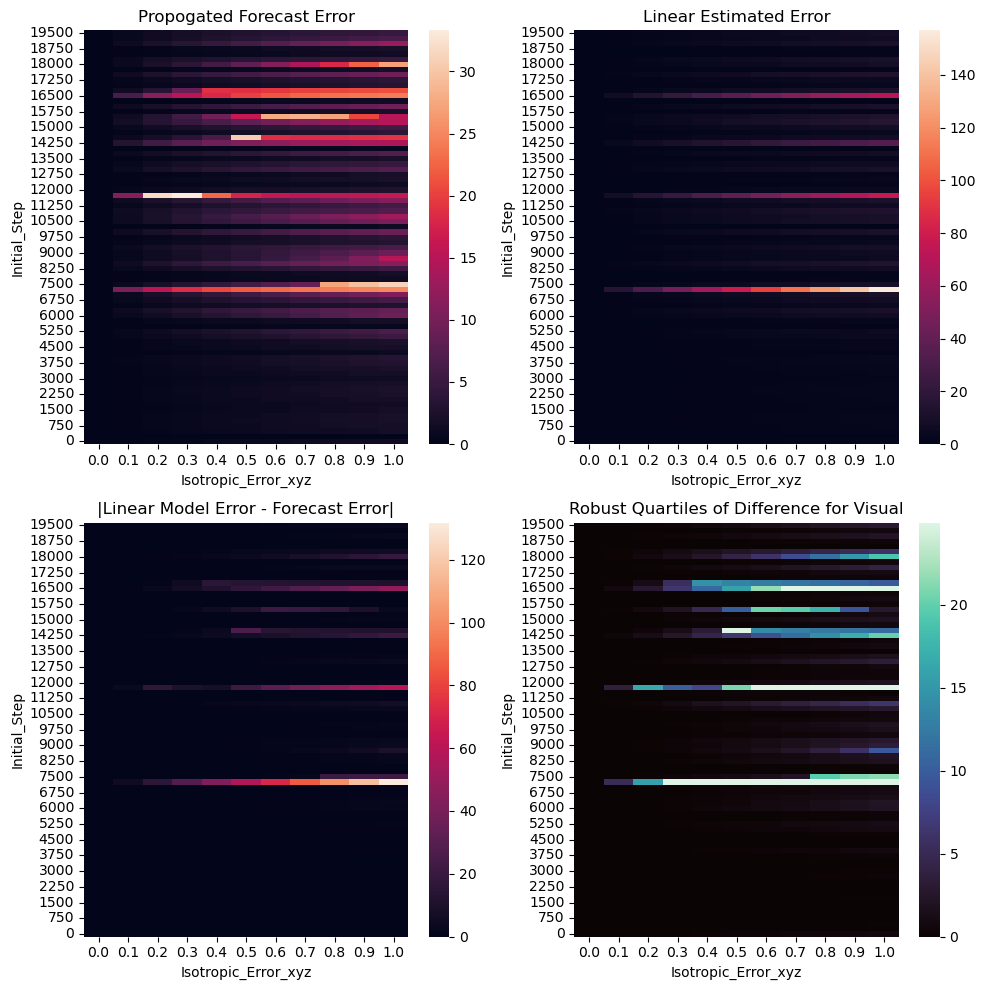

In [97]:
plt.rcParams["figure.figsize"] = [10.0, 10]
plt.rcParams["figure.autolayout"] = True

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)

sns.heatmap(fcst_error[isotropic_range], ax = ax1)
ax1.invert_yaxis()
ax1.set_title("Propogated Forecast Error")

sns.heatmap(TLM_error[isotropic_range], ax = ax2)
ax2.invert_yaxis()
ax2.set_title("Linear Estimated Error")

sns.heatmap(error_difference[isotropic_range], ax = ax3)
ax3.invert_yaxis()
ax3.set_title("|Linear Model Error - Forecast Error|")

sns.heatmap(error_difference[isotropic_range], ax = ax4, robust = True, cmap="mako")
ax4.invert_yaxis()
ax4.set_title("Robust Quartiles of Difference for Visual")

plt.setp(((ax1, ax2), (ax3,ax4)), xticks=ax2.get_xticks(), yticks=ax2.get_yticks(),xticklabels=ax2.get_xticklabels(), yticklabels=ax2.get_yticklabels())

print()